In [1]:
%load_ext autoreload

In [2]:
%autoreload
import os
import warnings
warnings.filterwarnings("ignore")
os.chdir(os.path.expanduser("/notebooks/segmentation"))

import numpy as np

from PIL import Image

from train_utils.utils import mIoU, Lion, Dice # pylint: disable=unused-import
from train_utils.unet_pipeline_trainer import train
from plotter.plot import plot_prediction

from batchflow.batchflow import B, V, Pipeline
from batchflow.batchflow.models.torch.unet import UNet as Unet_bf
from batchflow.batchflow.opensets.ade import ADESegmentation

In [3]:
train_params = {
    'BATCH_SIZE': 32,
    'LR': 1e-4,
    'NUM_CLASSES': 151,
    'NUM_EPOCHS': 90,
    'IMAGE_SHAPE': (256, 256)
}

In [4]:
dataset = ADESegmentation()
dataset.split([0.7, 0.2, 0.1], shuffle=False)

In [5]:
config = Unet_bf.default_config()

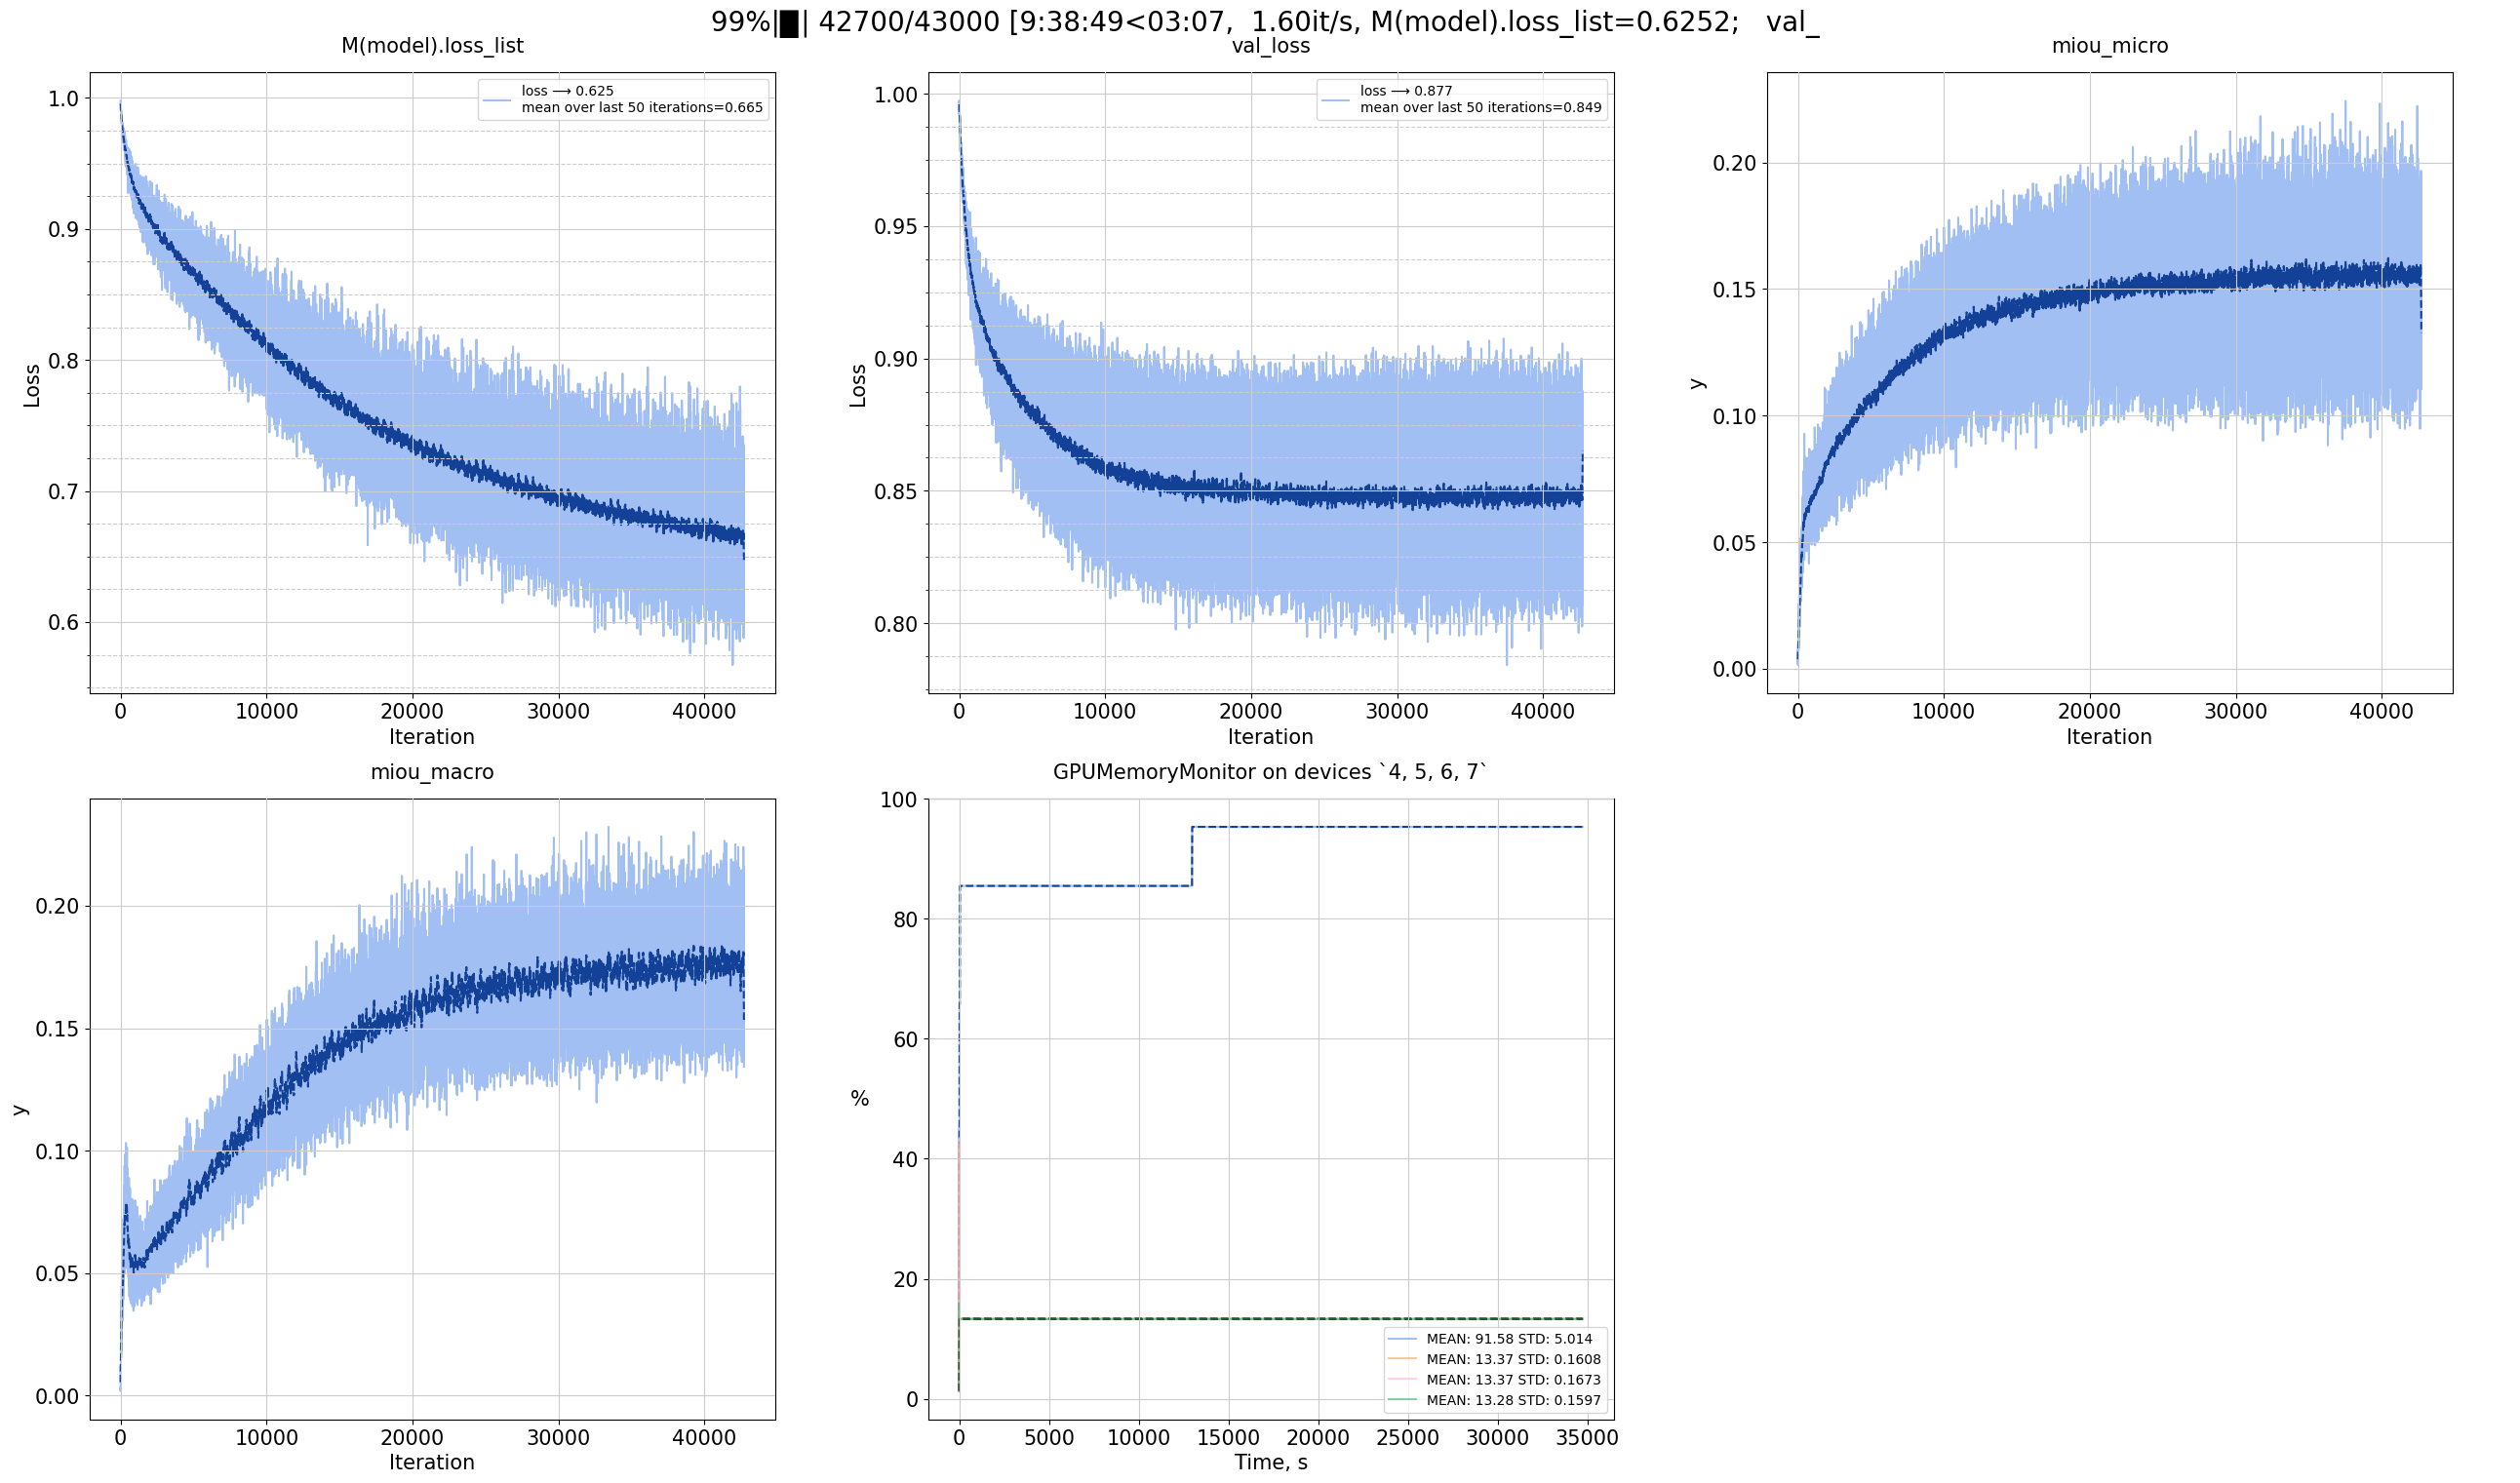

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [6]:
train_pipeline, val_pipeline = train(
    dataset=dataset,
    config=config,
    loss=Dice,
    optimizer={'name': Lion, 'lr': train_params['LR']},
    train_params=train_params,
    n_iters=43000,
    visible_devices='4,5,6,7',
    frequency=100
)

In [9]:
test_pipeline = (
    Pipeline()
    .import_model('model', train_pipeline)
    .init_variable('images', [])
    .init_variable('predictions', [])
    .init_variable('masks', [])
    .init_variable('iou', [])

    .resize(size=train_params['IMAGE_SHAPE'], resample=Image.Resampling.BILINEAR, src='images', dst='images')
    .to_array(channels='first', dtype=np.float32, src='images', dst='images')

    .resize(size=train_params['IMAGE_SHAPE'], resample=Image.Resampling.NEAREST, src='labels', dst='masks')
    .to_array(channels='first', dtype=np.int64, src='masks', dst='masks')

    .predict_model('model', inputs=B.images,
                   outputs='predictions', save_to=V('predictions', mode='a'))
    .update(V('images', mode='a'), B.images)
    .update(V('masks', mode='a'), B.masks)
    .mIoU(preds=V.predictions[-1], mask=B('masks'), num_classes=train_params['NUM_CLASSES'], save_to=V('iou', mode='a'))
) << dataset.test

test_pipeline = test_pipeline.run(batch_size=1, shuffle=False, n_epochs=1, drop_last=False, bar=True)

  0%|                                                                                                         …

In [10]:
np.mean(test_pipeline.v('iou'))

0.18613273

# Results

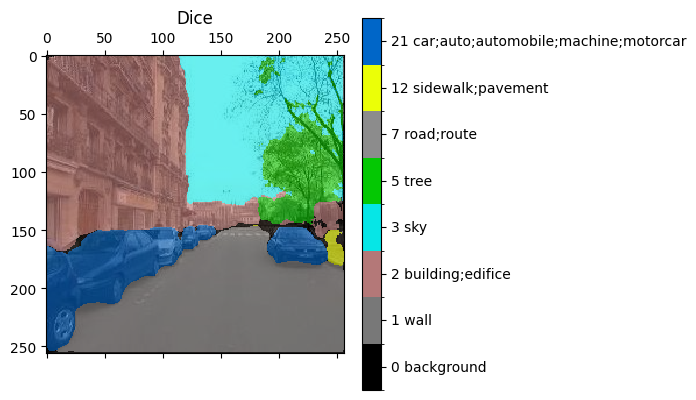

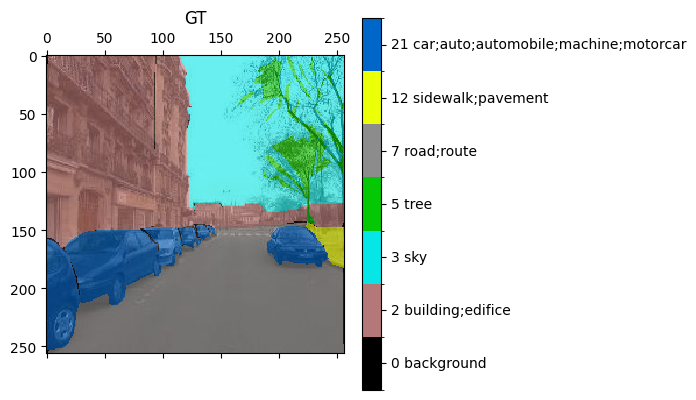

In [11]:
plot_prediction(pipeline=test_pipeline, alpha=0.6, image_number=6, dataset='ADE', title='Dice')

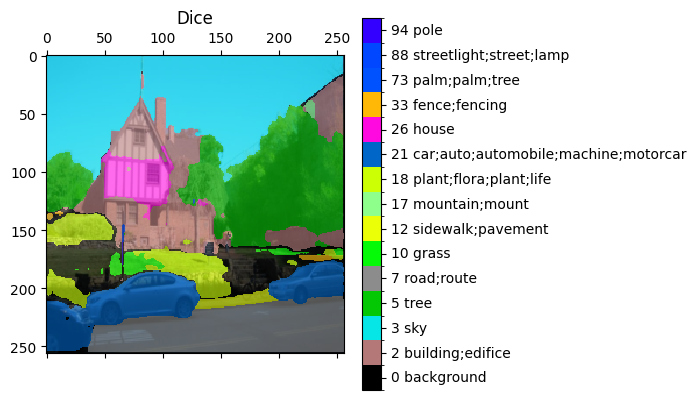

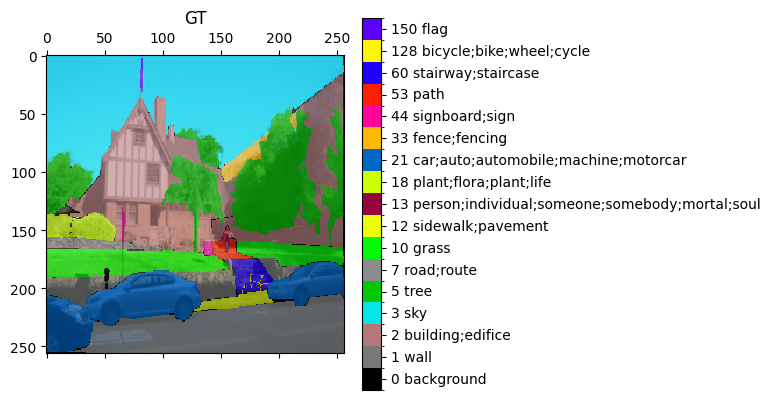

In [12]:
plot_prediction(pipeline=test_pipeline, alpha=0.6, image_number=0, dataset='ADE', title='Dice')

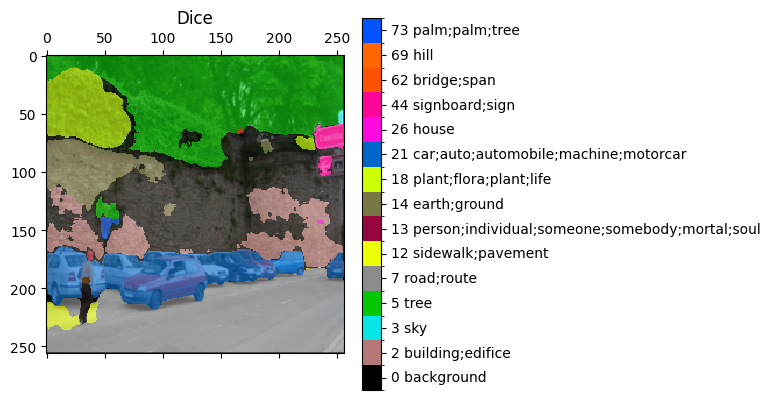

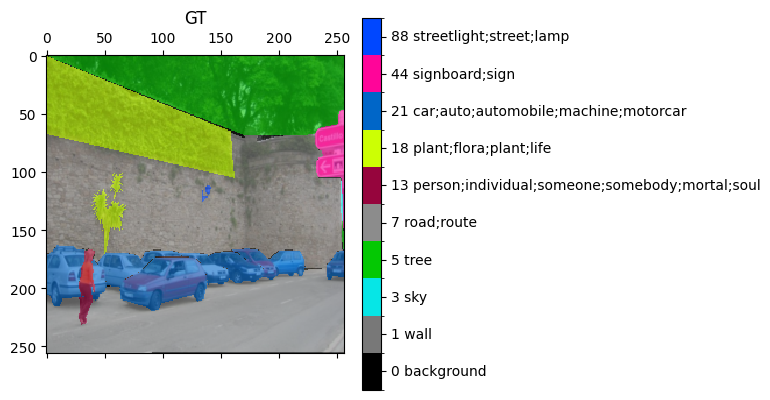

In [13]:
plot_prediction(pipeline=test_pipeline, alpha=0.6, image_number=10, dataset='ADE', title='Dice')

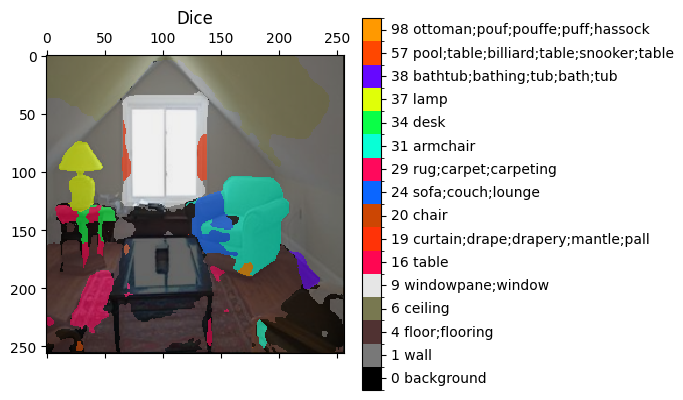

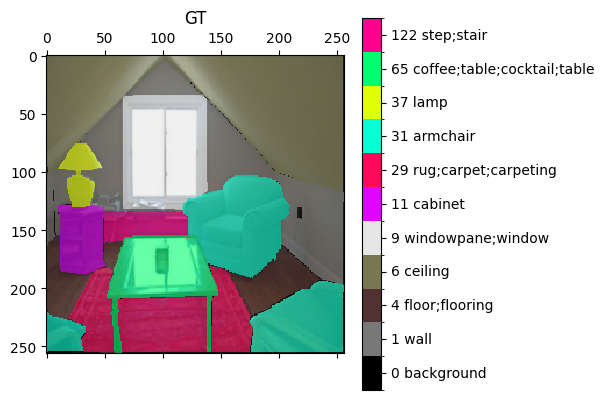

In [14]:
plot_prediction(pipeline=test_pipeline, alpha=0.6, image_number=100, dataset='ADE', title='Dice')

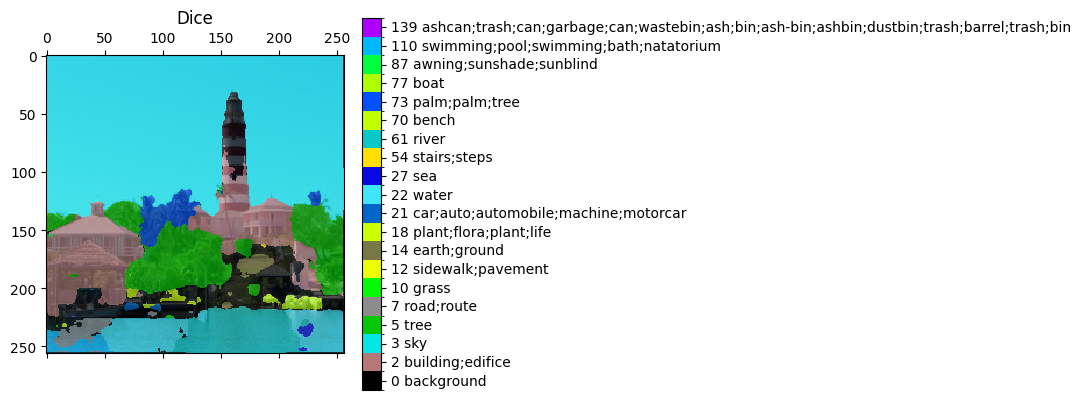

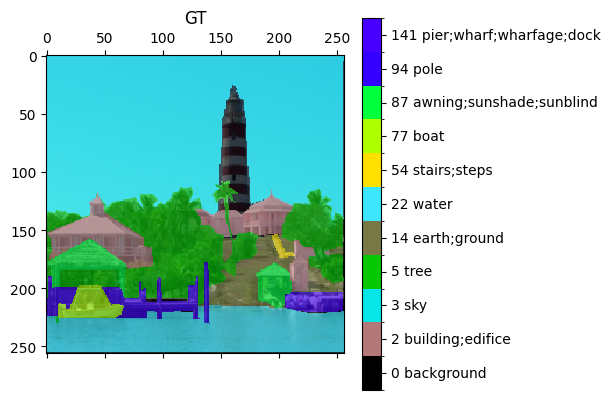

In [15]:
plot_prediction(pipeline=test_pipeline, alpha=0.6, image_number=150, dataset='ADE', title='Dice')

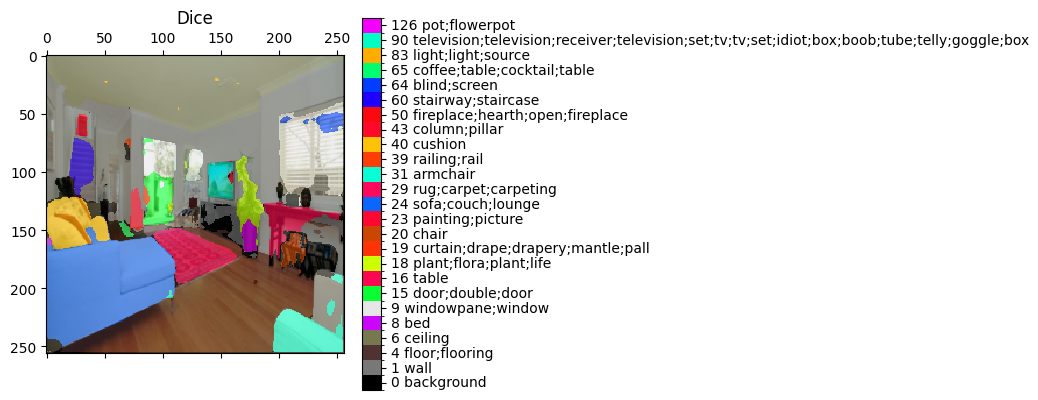

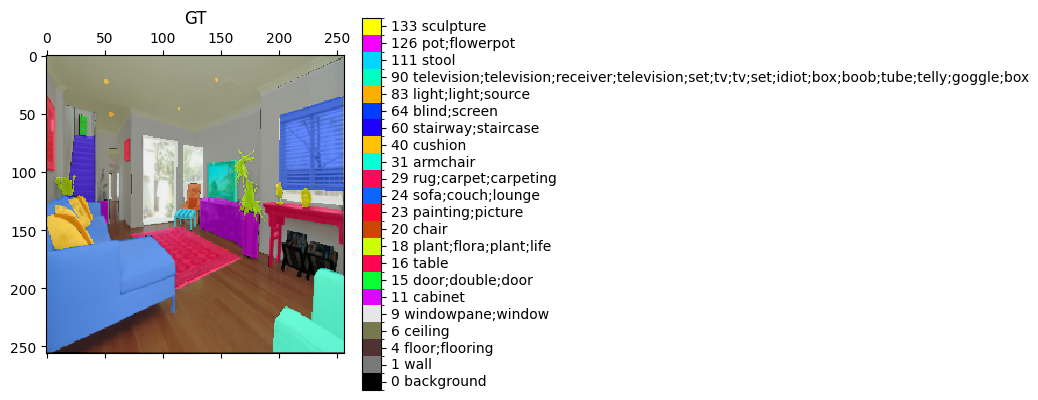

In [16]:
plot_prediction(pipeline=test_pipeline, alpha=0.6, image_number=200, dataset='ADE', title='Dice')

In [3]:
from nbtools import pylint_notebook
pylint_notebook()

Your code has been rated at 10.00/10 (previous run: 9.64/10, +0.36)
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
